# Towards Mind Wandering Adaptive Online Learning and Virtual Work Experiences
_By Colin Conrad_

April 11th, 2022

This script uses data described in Conrad & Newman (2021) to demonstrate how machine learning can be used to classify passive mind wandering as participants watch a long video. The data for this study are structured into ~4400 1.2 second epochs per participant. The epochs were recorded as responses to auditory tones that were elicited throughout a long video. The subjects were prompted at pseudo-random (i.e. seemingly random, but at the same time) intervals about their degree of experienced mind wandering, which was based on a five-point Likert scale. The epochs from the 10 seconds preceeding one of these prompts were given labels that corresponded to those responses, while the majority of the data remained unlabelled.

Our goal is to make use of this unlabelled data.

In this script, we do the following:
- Retrieve data from participants
- Conduct upsampling
- Conduct and apply the classifier to the unlabelled data
- Visualize the results

For more information or to cite this script, please refer to our the proceedings paper published by Conrad & Newman at the 2022 NeuroIS Retreat as well as the original paper:

Conrad, C., & Newman, A. (2021). Measuring Mind Wandering During Online Lectures Assessed With EEG. _Frontiers in Human Neuroscience_, 455. https://www.frontiersin.org/articles/10.3389/fnhum.2021.697532/full

For more information on the code used in this document, please refer to the reference below:

Conrad, C., Agarwal, O., Woc, C. C., Chiles, T., Godfrey, D., Krueger, K., ... & Newman, A. (2020). On Using Python to Run, Analyze, and Decode EEG Experiments. In _Information Systems and Neuroscience_ (pp. 287-293). Springer, Cham.

# 1. Retrieve data from participants
## Start by declaring the various libraries
We will import many libraries to achieve this task. A summary of the libraries are as follows:
- MNE, a library for managing and visualizing EEG data
- Matplotlib and Seaborn, for visualizing data
- Pandas and Numpy for managing data
- SKLearn for machine learning

In [1]:
%matplotlib inline
import matplotlib as plt
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300  
figsize=(4, 4)

import mne
import mne.stats
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from joblib import dump, load

from mne import io, pick_types, read_events, Epochs
from mne.decoding import Vectorizer, PSDEstimator
from mne.viz import tight_layout
from mne.decoding import CSP 
from mne.time_frequency import psd_multitaper
from mne.filter import filter_data


import numpy as np
import pandas as pd
mne.set_log_level('error')

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split

## Load epochs
Only 11 of the subjects reported a full range of responses to the mind wandering prompts. These are the subjects we observe in this notebook. Note that these corresponded to different numbers in the original dataset and they will henceforth be referred to in the new sequence. 

__Note__: The data is not avaliable for public use because participants did not consent to provide this data publicly. If you wish to access this data, please contact the author; we will have to apply to Dalhousie's Research Ethics Board for use.

In [2]:
mne.set_log_level('error')

data_path = '.'

subjects = [
    '01', # Participant 1
    '11', # Participant 2
    '14', # Participant 3
    '16', # Participant 4
    '20', # Participant 5
    '22', # Participant 6
    '25', # Participant 7
    '31', # Participant 8
    '40', # Participant 9
    '50', # Participant 10
    '51', # Participant 11
]

n_subjects = len(subjects)

all_epochs = []

for subject in subjects:
    print("working...")
    epochs = mne.read_epochs(data_path + '/' + subject + '/eeg_recordings/' + 'aalis-' + subject + '-epo.fif')
    all_epochs.append(epochs) #[epochs]

working...
working...
working...
working...
working...
working...
working...
working...
working...
working...
working...


# 2. Conduct Upsampling
## Specify only the MW1 and MW5 conditions for analysis
The MW1 condition represents epochs that preceeded a mind wandering prompt where participants reported being "completely on task". The MW5 condition represents epochs that preceeded a mind wandering prompt where participants reported being "completely mind wandering". We want to use these two conditions as our samples to maximize the efficacy of the classifier.

Participants were also subject to an auditory oddball throughout the experiment; each epoch thus represents a mind wandering/auditory tone pair. Our objective is to observe just the standard conditions for building, validating and observing the classifier.

In [3]:
cla = []
for i in all_epochs:
    mw = [i['MW1/Standard'],i['MW5/Standard']]
    mwc = mne.concatenate_epochs(mw)
    cla.append(mwc);

## Convert to psds
As described in Conrad & Newman (2021), oscillatory activity in the delta, theta and alpha bands were a strong predictor of hightened mind wandering. As such, we would benefit by converting the data to power spectral density. We will use the multitaper method, which will convert all of the data to a three dimensional matrix representing `n_epochs`, `n_channels` and `n_freqs`. [This is described in more detail in MNE's docs](https://mne.tools/stable/generated/mne.time_frequency.psd_multitaper.html).

To build the classifier, we need to retrieve the data labels and reshape the data into something usable. The code below will retireve the data labels and then reshape the psd data into a two dimensional array that is readable by machine learning algorithms.

In [4]:
labels = []
psds = []

for c in cla:
    labels.append(c.events[:, -1]) # append labels for each bin
    psd, freq = psd_multitaper(c, fmin=1, fmax=30)
    psd = 10 * np.log10(psd) # normalize
    reshaped_psd = psd.reshape(len(psd), len(psd[0]) * len(psd[0][0])) # convert the data into a two dimensional array
    psds.append(reshaped_psd)

## Upsample minority class
Machine learning should be conducted on each participant individually, because the variances in the signals will be substantial between subjects. However, we have a major problem: we have a very limited number of samples for each participant, and worse, the data are imbalanced. If we simply build a classifer that contrasts stats of on task thought with mind wandering, the classifier will reliably fall to the majority. 

Fortunately, machine learning gurus have found a way around this problem, by using resampling. Resampling (also called bootstrapping) is a way of leveraging the distribution of the data to create similar artificial data. Using SKLearn's `resample` utility, we can balance the classes. The script below will fill our whichever of the two classes (MW1, _completely on task_; MW5, _completely mind wandering_) was smaller.

In [5]:
upsampled = []
uplabels = []

for i in range(0,len(psds)):
    print("working...")
    mw = []
    ot = []
    
    these_samples = []
    these_labels = []
    

    for j in range (0, len(psds[i])):
        if labels[i][j] == 15:
            mw.append(psds[i][j])
        else:
            ot.append(psds[i][j])

    if len(mw) < len(ot): # if mw is less than ot, upsample it
        up = resample(mw,
                      replace=True,
                      n_samples=len(ot),
                      random_state=42)
        for u in up:
            these_samples.append(u)
            these_labels.append(5)
        for o in ot: 
            these_samples.append(o)
            these_labels.append(1)

    else: # else the opposite
        up = resample(ot,
                     replace=True,
                     n_samples=len(mw),
                     random_state=42)
        for u in up:
            these_samples.append(u)
            these_labels.append(1)
        for m in mw: 
            these_samples.append(m)
            these_labels.append(5)
    
    upsampled.append(these_samples)
    uplabels.append(these_labels)

working...
working...
working...
working...
working...
working...
working...
working...
working...
working...
working...


## Prepare the unlabelled data
Finally, we need to prepare the unlabelled data as well. While the labelled data had mind wandering indicator labels, this data did not, and represents the majority of our data. It would be desirable to find a way to detect whether participants experienced mind wandering during times when they were not prompted.

We will have to do some wizardry to this data though. We will start by retrieving the times of the epochs in a list, and then convert the unlabelled data into psd format, just like the labelled data.

In [6]:
# Retrieves the times

unlabelled_times = []

for e in all_epochs:
    unlabelled_times.append(e['Unlabelled/Standard'].events[:,0])

In [7]:
# Converts the unlabelled data into psds

unlabelled_epochs = []
unlabelled_psds = []

for e in all_epochs:
    print("working...")
    unlabelled_epochs.append(e['Unlabelled/Standard'])
    psd, freq = psd_multitaper(e['Unlabelled/Standard'], fmin=1, fmax=30) 
    psd = 10 * np.log10(psd) # normalize
    reshaped_psd = psd.reshape(len(psd), len(psd[0]) * len(psd[0][0]))
    unlabelled_psds.append(reshaped_psd)

working...
working...
working...
working...
working...
working...
working...
working...
working...
working...
working...


# 3. Conduct evaluation and apply the classifier to the unlabelled data
Linear discriminant analysis is a very common technique in EEG classification. It has a long and varied history, not least with brain computer interfaces. In our case, it is no surprise that it works effectively.

The script below creates classifiers for the 11 participants and prints its accuracy. The classifiers are also applied to the unlabelled epochs. If you are intereseted the accuracies of the classifications on the upsampled data, these are printed by the script below. My key takaways:
- The LDA classifier had over 80% accuracy for 7 participants
- Of the 4 participants that did not have high accuracy, the classifier performed above 65%
- Though this classifier is not perfect, it gives a rough estimate of whether the data reflected mind wandering

In [8]:
new_labels = []

for i in range(0,len(upsampled)):

    print("working...")
    #cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    clf = LinearDiscriminantAnalysis()
    
    sam = np.asarray(upsampled[i])
    lab = np.asarray(uplabels[i])
    preds = np.empty(len(labels))

    sam_sparse = coo_matrix(sam)
    sam, sam_sparse, lab = shuffle(sam, sam_sparse, lab, random_state=42)

    sam_train, sam_test, lab_train, lab_test = train_test_split(sam, lab, test_size=0.33, random_state=42)
    clf.fit(sam_train, lab_train)
    preds = clf.predict(sam_test)

    report = classification_report(lab_test, preds)
    acc = accuracy_score(lab_test, preds)
    
    # use the classifier to classify the unlabelled epochs
    new_labels.append(clf.predict(unlabelled_psds[i]))
    
    '''
    #change these as needed
    print("Results for Bin " + str(i+1) + ":")
    print(report)
    print("Confusion Matrix:")
    print("")
    conf = confusion_matrix(labels, preds)
    print(conf)
    print("")
    
    '''
    print("Accuracy for participant " + str(i+1) + ": " + str(acc))
    print("")

working...
Accuracy for participant 1: 0.972972972972973

working...
Accuracy for participant 2: 1.0

working...
Accuracy for participant 3: 0.4444444444444444

working...
Accuracy for participant 4: 0.9

working...
Accuracy for participant 5: 0.7

working...
Accuracy for participant 6: 0.8333333333333334

working...
Accuracy for participant 7: 0.7894736842105263

working...
Accuracy for participant 8: 0.8

working...
Accuracy for participant 9: 0.75

working...
Accuracy for participant 10: 0.8461538461538461

working...
Accuracy for participant 11: 0.7894736842105263



# 4. Visualize the results
## Adjust and aggregate the times
Now that we have the labels, we want to aggregate and compare the data in a way that is usable. We will start by adjusting the times to actual seconds. MNE records times in a way that needs to be adjusted to the sampling frequency, in this case 512 Hz. 

In [9]:
modified_times = []

for u in unlabelled_times:
    mod = []
    for t in u:
        cor = t/.512 # convert for the 512 hz sampling rate
        rnd = int(math.ceil(cor/100000)) * 100 # converted to seconds, rounded to the ten second mark
        mod.append(rnd)
    modified_times.append(mod)

## Retrieve the mind wandering prompts
These were the responses to the mind wandering questionnaires, which we will add to our visualizations. These are retrieve from `experience_samples.csv`, a record of the behavioural responses to the mind wandering prompts.

In [10]:
# these were their survey responses, with their original numbers in comments

responses = [
    [2,1,2,1,3,2,5,1,4,1], #01
    [2,2,3,4,3,4,5,3,3,1], #11
    [2,2,2,1,4,4,4,5,3,4], #14
    [2,3,4,3,4,5,5,4,1,2], #16
    [1,3,2,2,4,3,4,5,2,1], #20
    [2,2,3,3,4,4,4,5,1,1], #22
    [2,1,2,1,3,3,3,4,5,5], #25
    [1,1,2,2,3,3,4,4,5,4], #31
    [2,3,2,3,5,5,5,2,3,1], #40
    [2,1,1,1,3,4,4,5,5,5], #50
    [3,2,1,2,4,3,4,5,5,4], #51
]

response_times = [
    [275,512,620,908,1808,2570,3195,3375,4087,4267],
    [275,512,620,908,1808,2570,3195,3375,4087,4267],
    [275,512,620,908,1808,2570,3195,3375,4087,4267],
    [275,512,620,908,1808,2570,3195,3375,4087,4267],
    [275,512,620,908,1808,2570,3195,3375,4087,4267],
    [275,512,620,908,1808,2570,3195,3375,4087,4267],
    [275,512,620,908,1808,2570,3195,3375,4087,4267],
    [275,512,620,908,1808,2570,3195,3375,4087,4267],
    [275,512,620,908,1808,2570,3195,3375,4087,4267],
    [275,512,620,908,1808,2570,3195,3375,4087,4267],
    [275,512,620,908,1808,2570,3195,3375,4087,4267]
]

## Visualize the participants' data
The script below creates a grouped dataframe that averages the classified EEG data over periods of 10 seconds. This method is very much a work in progress, but represents my first attempt to use the ML classifier in this way. As we will see below, for many of the participants, the clasisfication is aligned with the responses given by the participants.

Though there is a lot more that can be done here. For example:
- Observe longer epochs, or different methods for aggregating time
- Perform semi-supervised learning 
- Conduct a followup study with additional mind wandering samples
- Oberve a different mind wandering sampling method

The classifier that we observed clearly did not work well for all participants, but might have worked well for many. Regardless, these results take the first steps towards a passivemachine learning classifier for detewcting mind wandering states during technology use.

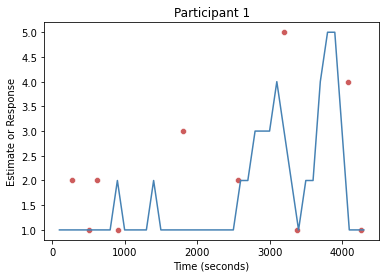

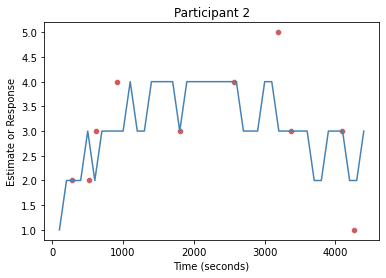

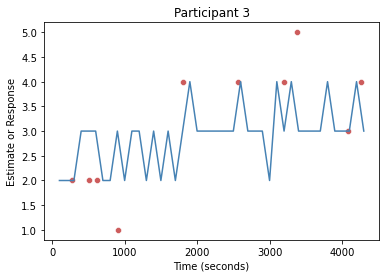

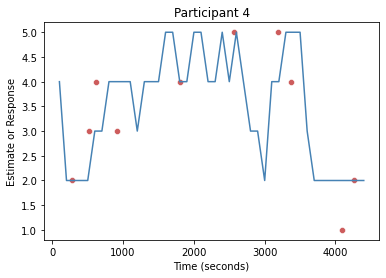

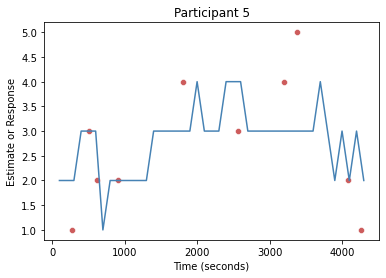

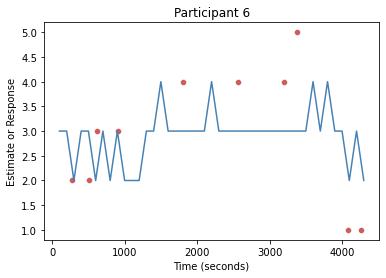

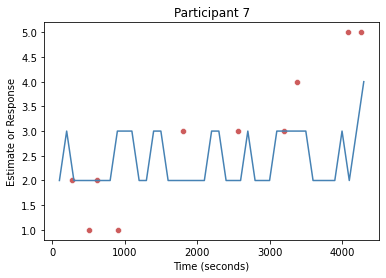

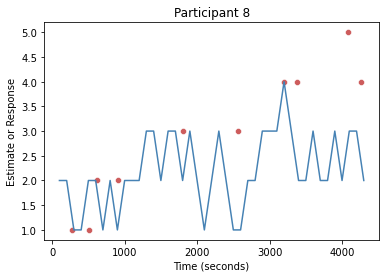

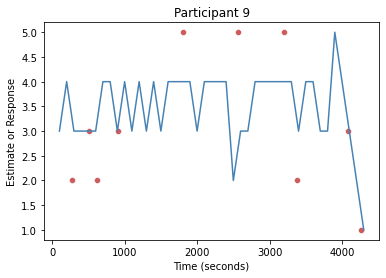

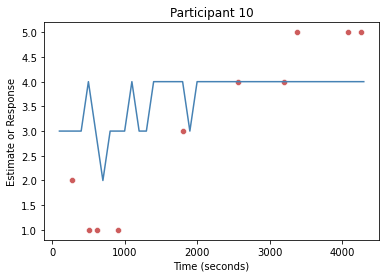

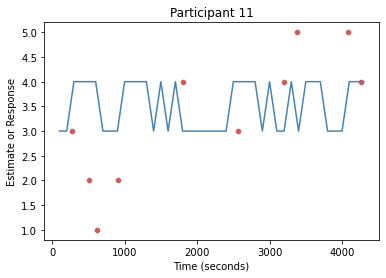

In [11]:
%matplotlib inline

i = 0

for i in range(0,11):
    ind_data = pd.DataFrame()
    ind_data['time'] = modified_times[i]
    ind_data['estimate'] = new_labels[i].astype(int)

    grouped = ind_data.groupby(['time']).mean()
    grouped['r_estimate'] = grouped['estimate'].round()

    p = sns.lineplot(data=grouped, x="time", y='r_estimate', color='steelblue')
    p.set_title('Participant ' + str(i+1), fontsize=12)
    p.set_xlabel('Time (seconds)', fontsize=10) 
    p.set_ylabel('Estimate or Response', fontsize=10) 

    ind_data = pd.DataFrame()
    ind_data['response_time'] = response_times[i]
    ind_data['response'] = responses[i]

    sns.scatterplot(data=ind_data, x="response_time", y='response', color="indianred")
    plt.savefig('ml_comp_p' + str(i+1) + '.png', dpi=300)
    plt.show()
    
    i+=1